# 单模型fine-tune

In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.pyplot as plt
import os

np.random.seed(2018)

/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
input_size = (299, 299, 3)


## 生成预训练feature

In [6]:
def gen_feature(MODEL, model_name: str, input_size: tuple, train_dir: str, val_dir: str, pre_process_func, batch_size=64):
    img_w = input_size[0]
    img_h = input_size[1]
    x = Input((img_h, img_w, 3))
    x = Lambda(pre_process_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    img_gen = ImageDataGenerator()
    train_data_gen = img_gen.flow_from_directory(train_dir, input_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    train_feature = model.predict_generator(train_data_gen, len(train_data_gen), verbose=1)
    val_data_gen = img_gen.flow_from_directory(val_dir, input_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    val_feature = model.predict_generator(val_data_gen, len(val_data_gen), verbose=1)
    
    h5_file = "feature_pretrain_%s.h5"%model_name
    if os.path.isfile(h5_file):
        os.remove(h5_file)
    
    with h5py.File(h5_file) as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("label", data=train_data_gen.classes)
        h.create_dataset("val", data=val_feature)
        h.create_dataset("val_label", data=val_data_gen.classes)
    

In [8]:
gen_feature(Xception, 'Xception', input_size[:-1], train_dir='pretrain', val_dir='val',
            pre_process_func=xception.preprocess_input, batch_size=128)

Found 1991 images belonging to 2 classes.
16/16 [==============================] - 23s 1s/step
Found 4979 images belonging to 2 classes.
39/39 [==============================] - 55s 1s/step


## 预训练分类器

### 读取预训练数据

In [9]:
h5_file = "feature_pretrain_Xception.h5"

with h5py.File(h5_file, 'r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['label'])
    X_val = np.array(h['val'])
    y_val = np.array(h['val_label'])

X_train, y_train = shuffle(X_train, y_train)


In [9]:
print(X_train.shape)

(1991, 2048)


### 构建分类器

In [10]:
def build_model(input_shape, drop_prob: float, lr=1e-2):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model = build_model(X_train.shape[1:], 0.7, lr=1e-3)

### 使用10%的数据训练分类器

In [22]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='pretrain_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 1991 samples, validate on 4979 samples
Epoch 1/50
1991/1991 [==============================] - 2s 920us/step - loss: 0.5517 - acc: 0.7509 - val_loss: 0.3429 - val_acc: 0.9865
Epoch 2/50
1991/1991 [==============================] - 0s 89us/step - loss: 0.2774 - acc: 0.9719 - val_loss: 0.1858 - val_acc: 0.9908
Epoch 3/50
1991/1991 [==============================] - 0s 84us/step - loss: 0.1682 - acc: 0.9864 - val_loss: 0.1238 - val_acc: 0.9916
Epoch 4/50
1991/1991 [==============================] - 0s 91us/step - loss: 0.1206 - acc: 0.9910 - val_loss: 0.0946 - val_acc: 0.9926
Epoch 5/50
1991/1991 [==============================] - 0s 114us/step - loss: 0.0970 - acc: 0.9900 - val_loss: 0.0776 - val_acc: 0.9930
Epoch 6/50
1991/1991 [==============================] - 0s 112us/step - loss: 0.0823 - acc: 0.9874 - val_loss: 0.0664 - val_acc: 0.9938
Epoch 7/50
1991/1991 [==============================] - 0s 118us/step - loss: 0.0725 - acc: 0.9910 - val_loss: 0.0586 - val_acc: 0.9938
Epo

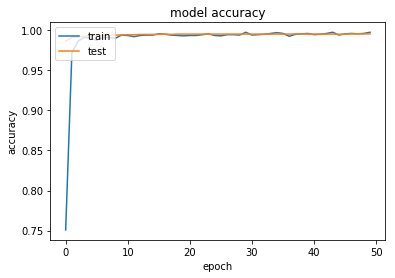

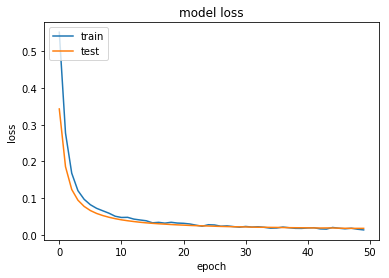

In [23]:
plot_history(history)

## 构建fine-tune模型

In [24]:
def build_finetune_model(MODEL, pre_process_func, input_size, trainable_layers: int, drop_prob: float):
    input_tensor = Input(input_size)
    x = Lambda(pre_process_func)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(drop_prob)(x)
    pred = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    
    model = Model(base_model.input, pred)
    
    return model
    

In [27]:
model = build_finetune_model(Xception, xception.preprocess_input, input_size=input_size, trainable_layers=6, drop_prob=0.7)
model.load_weights('pretrain_Xception.h5', by_name=True)
opt = optimizers.Adam(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 299, 299, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_4[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 使用剩余90%训练数据fine-tune模型

In [ ]:
batch_size = 64
img_gen = ImageDataGenerator()

In [31]:
train_data_gen = img_gen.flow_from_directory('finetune', input_size[:-1], class_mode='binary', batch_size=batch_size)
validation_gen = img_gen.flow_from_directory('val', input_size[:-1], class_mode='binary', batch_size=batch_size)

Found 17925 images belonging to 2 classes.
Found 4979 images belonging to 2 classes.


测试预训练模型：

In [33]:
model.evaluate_generator(validation_gen, steps=len(validation_gen))

[0.01791653083628004, 0.9955814420566379]

调整模型参数：

In [40]:
model = build_finetune_model(Xception, xception.preprocess_input, input_size=input_size, trainable_layers=6, drop_prob=0.9)
model.load_weights('pretrain_Xception.h5', by_name=True)

opt = optimizers.Adam(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

训练模型：

In [41]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
             ModelCheckpoint(filepath='finetune_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit_generator(train_data_gen, steps_per_epoch=len(train_data_gen), epochs=10,
                              validation_data=validation_gen, validation_steps=len(validation_gen), callbacks=callbacks)

Epoch 1/10
281/281 [==============================] - 238s 848ms/step - loss: 0.0782 - acc: 0.9748 - val_loss: 0.0177 - val_acc: 0.9956
Epoch 2/10
281/281 [==============================] - 232s 826ms/step - loss: 0.0340 - acc: 0.9878 - val_loss: 0.0162 - val_acc: 0.9956
Epoch 3/10
281/281 [==============================] - 231s 822ms/step - loss: 0.0245 - acc: 0.9914 - val_loss: 0.0161 - val_acc: 0.9960
Epoch 4/10
281/281 [==============================] - 232s 827ms/step - loss: 0.0184 - acc: 0.9923 - val_loss: 0.0169 - val_acc: 0.9956
Epoch 5/10
281/281 [==============================] - 233s 829ms/step - loss: 0.0168 - acc: 0.9943 - val_loss: 0.0235 - val_acc: 0.9930
Epoch 6/10
281/281 [==============================] - 232s 827ms/step - loss: 0.0214 - acc: 0.9941 - val_loss: 0.0194 - val_acc: 0.9942


In [ ]:
plot_history(history)

## 尝试图像增强

In [ ]:
augmentation_gen =  ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                       shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_data_gen = augmentation_gen.flow_from_directory('finetune', input_size[:-1], class_mode='binary', batch_size=batch_size)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
             ModelCheckpoint(filepath='finetune_augmentation_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit_generator(train_data_gen, steps_per_epoch=len(train_data_gen), epochs=10,
                              validation_data=validation_gen, validation_steps=len(validation_gen), callbacks=callbacks)

## 预测测试集数据

In [44]:
model.load_weights('finetune_Xception.h5')

In [45]:
img_gen = ImageDataGenerator()
test_data_gen = img_gen.flow_from_directory('test', (input_size[:-1]), shuffle=False, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [47]:
y_pred = model.predict_generator(test_data_gen, len(test_data_gen), verbose=1)
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

196/196 [==============================] - 139s 711ms/step


In [48]:
df = pd.read_csv("sampleSubmission.csv")

for i, fname in enumerate(test_data_gen.filenames):
    index = int(fname[fname.rfind(os.sep) + 1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
